# MultiNest sampling

This example demonstrates how to use MultiNest sampling [1] to sample from the posterior distribution for a logistic model fitted to model-simulated data.

[1] "MultiNest: an efficient and robust Bayesian inference tool for cosmology and particle physics."
Feroz, F., M. P. Hobson, and M. Bridges. Monthly Notices of the Royal Astronomical Society 398.4 (2009): 1601-1614.

MultiNest works similarly to [ellipsoidal nested sampling](nested-ellipsoidal-sampling.ipynb) by proposing points using the prior but constraining the proposals such that they lie within ellipsoids of known high density. A key difference is that MultiNest uses (potentially) many ellipsoids to generate proposals, unlike ellipsoidal nested sampling, which uses only a single ellipsoid.

## Ellipsoids and ellipsoid trees

We illustrate this using the `Ellipsoid()` and `EllipsoidTree()` classes in PINTS. Whilst users do not need these to perform inference, we use them here to visualise the ellipses generated by fitting to two-dimensional data.

We first generate some sample data which we'll fit bounding ellipses to.

In [1]:
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt

We'll first draw some data from the [AnnulusLogPDF](../toy/http://localhost:8888/notebooks/pints/examples/toy/distribution-annulus.ipynb) example. Note that the ellipsoid tree methods work only within the unit cube, so we transform all points to lie within the [0,1]^2 range.

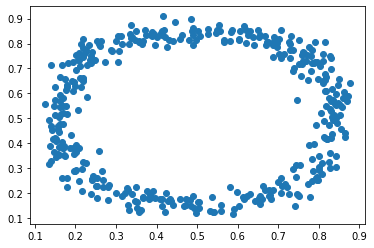

In [2]:
n = 400
log_pdf = pints.toy.AnnulusLogPDF()
draws = log_pdf.sample(n)
gaussian = pints.MultivariateGaussianLogPrior([0, 0], [[100, 0], [0, 100]])
draws = [gaussian.convert_to_unit_cube(x) for x in draws]
draws = np.vstack(draws)

plt.scatter(draws[:, 0], draws[:, 1])
plt.show()

Now we'll fit an ellipsoid tree to the data, which provides an ellipsoidal decomposition of the domain covered by the sample draws.

In [3]:
from pints._nested.__init__ import Ellipsoid
from pints._nested._multinest import EllipsoidTree

iteration = 600 # this number can be ignored for understanding this method for now
ellipsoid_tree = EllipsoidTree(draws, iteration)

Now plotting the ellipsoids (here, because the domain is 2D, these are actually ellipses) resultant from the spatial decomposition.

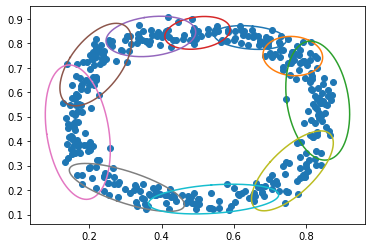

In [4]:
def plot_2d_ellipsoid(ellipsoid):
    A = ellipsoid.weight_matrix()
    c = ellipsoid.centroid()

    U, D, V = np.linalg.svd(A)

    # major and minor axes
    a = 1 / np.sqrt(D[0])
    b = 1 / np.sqrt(D[1])

    # generate x and y
    theta = np.linspace(0, 2 * np.pi, 1000)
    state_1 = a * np.cos(theta)
    state_2 = b * np.sin(theta)
    state = np.vstack((state_1, state_2))
    z = np.matmul(V, state)
    x = z[0, :] + c[0]
    y = z[1, :] + c[1]

    plt.plot(x, y)

def plot_2d_ellipsoid_tree_leaves(ellipsoid_tree):
    ellipsoids = ellipsoid_tree.leaf_ellipsoids()
    for ellipsoid in ellipsoids:
        plot_2d_ellipsoid(ellipsoid)
        
plot_2d_ellipsoid_tree_leaves(ellipsoid_tree)
plt.scatter(draws[:, 0], draws[:, 1])
plt.show()

This ellipsoidal decomposition in stochastic: each replicate can yield a different decomposition.

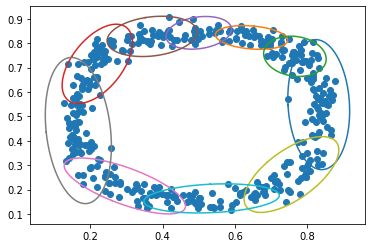

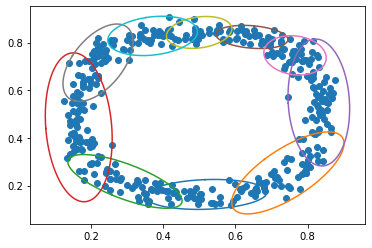

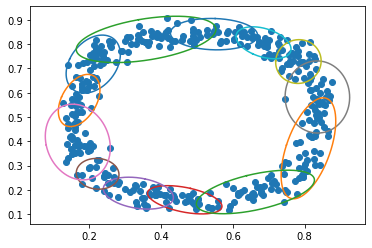

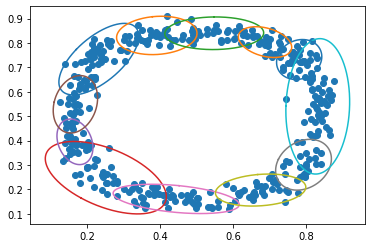

In [5]:
nreps = 4
for i in range(nreps):
    ellipsoid_tree = EllipsoidTree(draws, iteration)

    plot_2d_ellipsoid_tree_leaves(ellipsoid_tree)
    plt.scatter(draws[:, 0], draws[:, 1])
    plt.show()

In MultiNest, this ellipsoidal decomposition would be used to generate proposals which have an improved change of being accepted as part of a nested sampling algorithm. In PINTS' implementation of the ellipsoidal tree, we can sample uniformly within these ellipsoid set. This accounts for the overlap in the ellipses to ensure uniform sampling within the set.

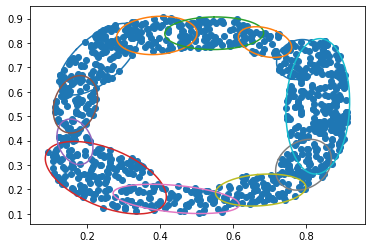

In [6]:
test_draws = ellipsoid_tree.sample_leaf_ellipsoids(1000)
test_draws = np.vstack(test_draws)

plot_2d_ellipsoid_tree_leaves(ellipsoid_tree)
plt.scatter(test_draws[:, 0], test_draws[:, 1])
plt.show()

# Inference for the egg box problem

We now illustrate inference for the [egg box problem](distribution-simple-egg-box.ipynb): this problem is highly multimodal and causes issues for MCMC methods. Here, for ease of visualisation and to further separate the modes, we transform the dimensions.

In [7]:
class ExampleToy(pints.LogPDF):
    def __init__(self, sigma, r):
        self._sigma = sigma
        self._r = r
        self._log_toy = pints.toy.SimpleEggBoxLogPDF(self._sigma, self._r)

    def __call__(self, x):
        x1 = np.copy(x)
        x1[0] = -15 + 30 * x[0]
        x1[1] = -15 + 30 * x[1]
        return self._log_toy(x1)

    def n_parameters(self):
        return 2

log_pdf = ExampleToy(2, 4)
log_prior = pints.UniformLogPrior(
    [0.0, 0.0],
    [1.0, 1.0])

We set up the MultiNest sampler.

In [8]:
controller = pints.NestedController(log_pdf, log_prior, method=pints.MultiNestSampler)

# Set number of iterations
controller.set_iterations(2000)

# Set the number of posterior samples to generate
controller.set_n_posterior_samples(500)

# Set threshold for updating ellipsoids as sampling runs
controller.sampler().set_f_s_threshold(1.1)

We run the sampler: note that the ellipsoid tree may be updated as the sampler runs, resulting in differing numbers of ellipsoids in the decomposition over time.

In [9]:
samples = controller.run()
print('Done!')

Running MultiNest sampler
Number of active points: 400
Total number of iterations: 2000
Total number of posterior samples: 500
Iter. Eval. Time m:s Delta_log(z) Acceptance rate Ellipsoid count
0     1       0:00.0 -inf          1               0             
0     2       0:00.0 -inf          1               0             
0     21      0:00.0 -inf          1               0             
0     41      0:00.0 -inf          1               0             
0     61      0:00.0 -inf          1               0             
0     81      0:00.0 -inf          1               0             
0     101     0:00.0 -inf          1               0             
0     121     0:00.0 -inf          1               0             
0     141     0:00.0 -inf          1               0             
0     161     0:00.0 -inf          1               0             
0     181     0:00.0 -inf          1               0             
0     201     0:00.0 -inf          1               0             
0     221     0

We can plot the samples over the target density, and the draws appear to be a reasonable fit to the underlying density.

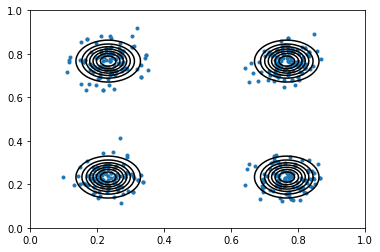

In [10]:
# Contour plot of pdf
levels = np.linspace(-100, 0, 20)
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
Z = [[np.exp(log_pdf([i, j])) for i in x] for j in y]

plt.figure()
plt.contour(X, Y, Z, colors='k')
plt.scatter(samples[:, 0], samples[:, 1], marker='.')
plt.show()

Throughout sampling, the number of ellipsoids in the decomposition can vary. We can, however, visualise the final decomposition used to draw sample points: note that, these ellipsoids will likely be smaller than the distribution of draws near the end of a sample run.

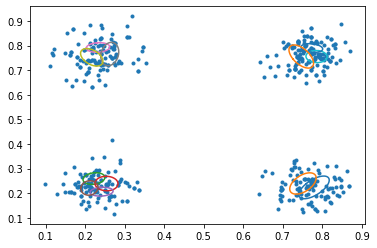

In [11]:
et = controller.sampler().ellipsoid_tree()
plot_2d_ellipsoid_tree_leaves(et)
draws = [log_prior.convert_to_unit_cube(x) for x in samples]
draws = np.vstack(draws)

plt.scatter(draws[:, 0], draws[:, 1], marker='.')
plt.show()

We can print the effective sample size...

In [12]:
print('effective sample size = ' + str(controller.effective_sample_size()))

effective sample size = 1329.7641810152445


...and print our estimate of the marginal likelihood.

In [13]:
print('marginal log-likelihood = ' + str(controller.marginal_log_likelihood())
      + ' ± ' + str(controller.marginal_log_likelihood_standard_deviation()))

marginal log-likelihood = -5.455629903164397 ± 0.05887368649303134


## Goodwin oscillator ODE model
We now use MultiNest to perform inference for the [Goodwin Oscillator model](../toy/model-goodwin-oscillator.ipynb), which can prove tricky for MCMC methods due to ripples in the posterior surface [1].

[1] Estimating Bayes factors via thermodynamic integration and population MCMC. Ben Calderhead and Mark Girolami, 2009, Computational Statistics and Data Analysis.

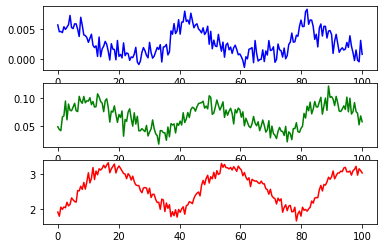

In [14]:
model = pints.toy.GoodwinOscillatorModel()
real_parameters = model.suggested_parameters()
times = model.suggested_times()
values = model.simulate(real_parameters, times)

noise1 = 0.001
noise2 = 0.01
noise3 = 0.1
noisy_values = np.array(values, copy=True)
noisy_values[:, 0] += np.random.normal(0, noise1, len(times))
noisy_values[:, 1] += np.random.normal(0, noise2, len(times))
noisy_values[:, 2] += np.random.normal(0, noise3, len(times))

plt.figure()
plt.subplot(3, 1, 1)
plt.plot(times, noisy_values[:, 0], 'b')
plt.subplot(3, 1, 2)
plt.plot(times, noisy_values[:, 1], 'g')
plt.subplot(3, 1, 3)
plt.plot(times, noisy_values[:, 2], 'r')
plt.show()

In [15]:
# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, values)

# Create a log posterior
log_prior = pints.UniformLogPrior([1, 1, 0.01, 0.01, 0.01], [10, 10, 1, 1, 1])
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, [noise1, noise2, noise3])
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Run MCMC on the noisy data
controller = pints.NestedController(log_likelihood, log_prior, method=pints.MultiNestSampler)
# Set number of iterations
controller.set_iterations(20000)

# Set the number of posterior samples to generate
controller.set_n_posterior_samples(2000)

# Set threshold for updating ellipsoids as sampling runs
controller.sampler().set_f_s_threshold(1.01)

samples = controller.run()
print('Done!')

Running MultiNest sampler
Number of active points: 400
Total number of iterations: 20000
Total number of posterior samples: 2000
Iter. Eval.  Time m:s Delta_log(z) Acceptance rate Ellipsoid count
0     1        0:00.0 -inf          1               0             
0     2        0:00.0 -inf          1               0             
0     21       0:00.1 -inf          1               0             
0     41       0:00.2 -inf          1               0             
0     61       0:00.4 -inf          1               0             
0     81       0:00.6 -inf          1               0             
0     101      0:00.7 -inf          1               0             
0     121      0:00.8 -inf          1               0             
0     141      0:00.9 -inf          1               0             
0     161      0:01.1 -inf          1               0             
0     181      0:01.2 -inf          1               0             
0     201      0:01.3 -inf          1               0             


1980  4489     0:18.3 -3514.09159   0.484225972     13            
2000  4557     0:18.6 -3462.309235  0.48111619      12            
2020  4613     0:18.7 -3410.319702  0.479468312     12            
2040  4665     0:18.9 -3355.519685  0.478311841     12            
2060  4735     0:19.1 -3286.216721  0.475201845     12            
2080  4786     0:19.2 -3249.182139  0.474236206     12            
2100  4881     0:20.7 -3212.683718  0.468645392     11            
2120  4956     0:20.9 -3174.455775  0.465320457     11            
2140  5059     0:21.2 -3143.588113  0.45932603563   11            
2160  5160     0:21.4 -3108.833503  0.453781512605  11            
2180  5259     0:21.6 -3066.886431  0.448651986     11            
2200  5340     0:22.0 -3025.554876  0.44534413      12            
2220  5490     0:22.4 -2982.66881   0.436149312     12            
2240  5601     0:22.6 -2943.640834  0.430686406     12            
2260  5693     0:22.9 -2924.875136  0.426979029     12        

4440  31081    1:29.6 -1076.5497    0.144714970177  12            
4460  31182    1:29.8 -1051.511838  0.144889871     12            
4480  31323    1:30.1 -1020.335778  0.144875982     12            
4500  31400    1:31.0 -1004.130071  0.14516129      12            
4520  31501    1:31.2 -986.2333546  0.145332947     12            
4540  31615    1:31.5 -967.2516123  0.145442896     12            
4560  31811    1:31.9 -937.1144366  0.145172073     12            
4580  31968    1:32.2 -913.2275123  0.145083629     12            
4600  32105    1:32.6 -896.3747742  0.145087526     12            
4620  32218    1:32.9 -877.2198558  0.145200829719  12            
4640  32322    1:33.1 -864.2425734  0.145354301109  12            
4660  32452    1:33.4 -874.4019522  0.145388743     12            
4680  32572    1:33.6 -858.1110846  0.145468109     12            
4700  32700    1:34.5 -835.5865977  0.145510836     12            
4720  32865    1:34.9 -821.8611569  0.14538734      12        

6900  43100    2:06.2 -90.07362094  0.161592506     12            
6920  43155    2:06.3 -88.04032894  0.161852415     12            
6940  43230    2:06.5 -86.10583569  0.162035956     12            
6960  43307    2:06.7 -84.05617129  0.162211294     12            
6980  43383    2:06.8 -82.19007786  0.162389782     12            
7000  43472    2:07.4 -80.51111647  0.162518574     12            
7020  43556    2:07.6 -78.69017154  0.162665678     12            
7040  43653    2:07.8 -77.46286814  0.162763277     12            
7060  43734    2:08.0 -76.2630185   0.16292057      12            
7080  43840    2:08.2 -74.81599825  0.162983425     12            
7100  43950    2:08.5 -73.59537382  0.163030999     13            
7120  44008    2:08.6 -72.10143361  0.163272794     13            
7140  44058    2:08.7 -70.68008656  0.163543909     13            
7160  44112    2:08.9 -69.37153389  0.163799414     13            
7180  44165    2:09.0 -68.00671716  0.164058037     13        

9360  49412    2:25.2 -7.224806038  0.190973639     12            
9380  49453    2:25.3 -7.059287298  0.19122174      12            
9400  49507    2:25.5 -6.896832277  0.191418739     12            
9420  49547    2:25.6 -6.741212594  0.191669888     12            
9440  49592    2:25.7 -6.590507261  0.191901122     12            
9460  49635    2:25.8 -6.444746493  0.192139738     12            
9480  49687    2:25.9 -6.302223922  0.192342808     12            
9500  49736    2:26.2 -6.162441386  0.192557159     11            
9520  49778    2:26.2 -6.018761071  0.192798412     11            
9540  49821    2:26.3 -5.876014301  0.193035349     11            
9560  49851    2:26.4 -5.734472367  0.19332268306   11            
9580  49897    2:26.5 -5.593907546  0.193547084     11            
9600  49947    2:26.7 -5.453987827  0.193755424     11            
9620  49979    2:26.7 -5.316109307  0.194033764     11            
9640  50013    2:26.8 -5.177289955  0.194303912     11        

The approach produces samples close to the generating parameter values.

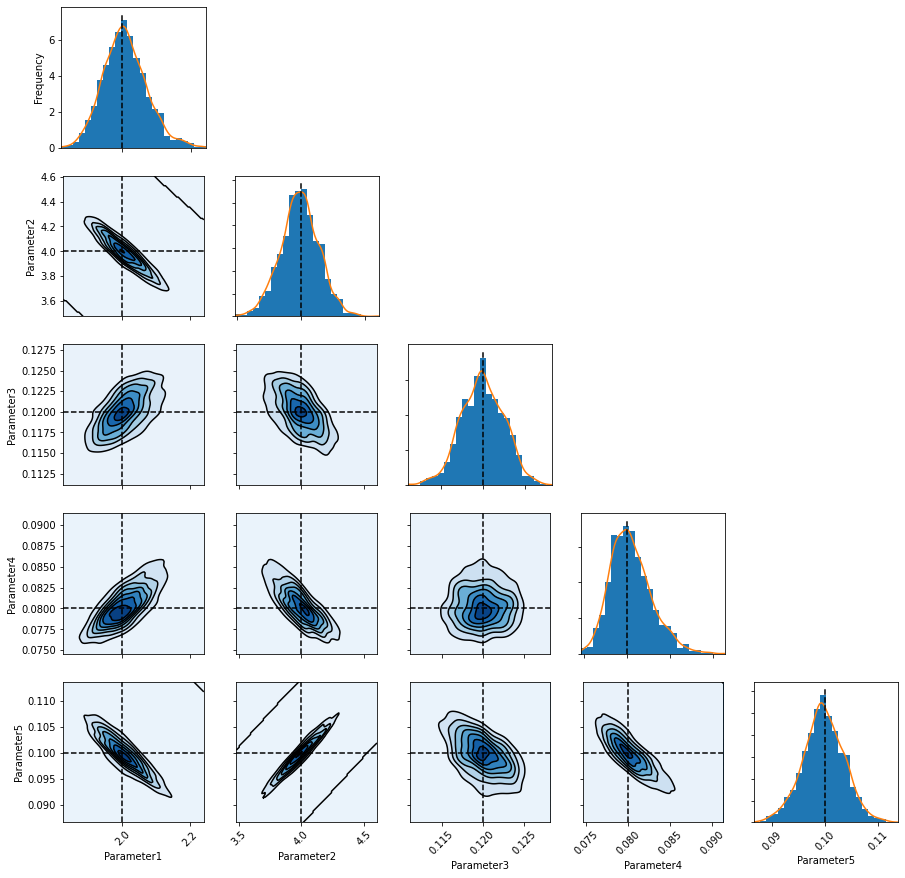

In [16]:
import pints.plot

pints.plot.pairwise(samples, kde=True, ref_parameters=real_parameters)
plt.show()